In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'computed-tomography-ct-of-the-brain:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3856259%2F6685411%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240812%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240812T145734Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4f3ce8d9e0c679b17c5a8bd0d2f8653cec7c2647cf1042c38a99c8021415324d1e5adce87a798b8369f78d4c2aa18a0f339b44c7b245867b4806db6f02245fcb104133ab08432443b92a082dab0c8114bd6d6e0504be828b9649992e10ce77d44a33f251e8b29d3a48f3cef7be89c6f64060c823c86841c88c8debafaf976ce1766b6ee4c2c2ced3f6bf6799252a2f00b04b60789c033fa4c1d3c545c9031c97a7b31c3018018ff2aaa9f0d3a42c02f8c4cc4ce493fded5ddd8ec8dd5f073aed9ac2aaae503f920ae6658466073e4109d61204e004d0348d19fe7dce1a6b5ed8d63aa2b2883314b4ec8e7ee248fe384435a053c68c6a9075167891063d20b778'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 69191139 bytes downloaded
Downloaded and uncompressed: computed-tomography-ct-of-the-brain
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import PIL as pl
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, AvgPool2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import  RandomBrightness, RandomFlip, RandomRotation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import os

import warnings
warnings.filterwarnings('ignore')

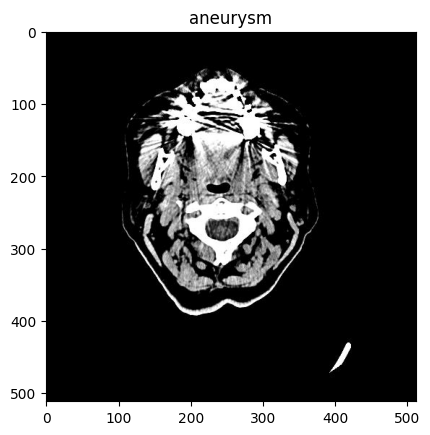

In [ ]:
img = cv2.imread('/kaggle/input/computed-tomography-ct-of-the-brain/files/aneurysm/0.jpg')
plt.title('aneurysm')
plt.imshow(img, label = 'aneurysm')

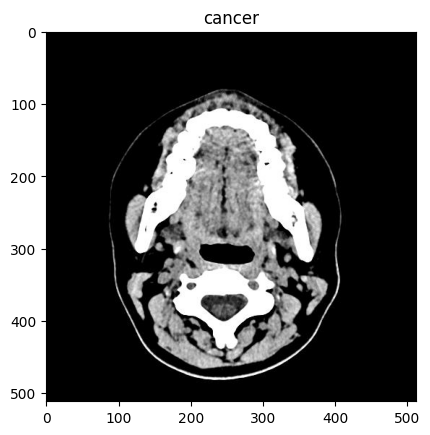

In [ ]:
img = cv2.imread('/kaggle/input/computed-tomography-ct-of-the-brain/files/cancer/0.jpg')
plt.title('cancer')
plt.imshow(img)

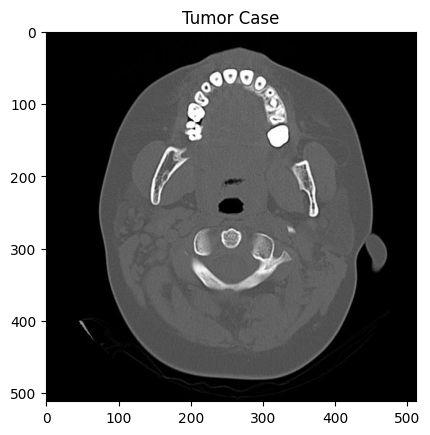

In [ ]:
img = cv2.imread('/kaggle/input/computed-tomography-ct-of-the-brain/files/tumor/0.jpg')
plt.title('Tumor Case')
plt.imshow(img)

In [ ]:
img.shape

(512, 512, 3)

In [ ]:
dir = '/kaggle/input/computed-tomography-ct-of-the-brain/files'
img_width = 400
img_height = 400

In [ ]:
train_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.3, subset = "training")
test_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.2, subset = "validation")
val_data = image_dataset_from_directory(dir,label_mode = "categorical", image_size = (img_height, img_width),batch_size = 10, shuffle = True,seed = 12, validation_split = 0.1, subset = "validation")

Found 259 files belonging to 3 classes.
Using 182 files for training.
Found 259 files belonging to 3 classes.
Using 51 files for validation.
Found 259 files belonging to 3 classes.
Using 25 files for validation.


## Data Augmentation

In [ ]:
augmentation = Sequential()

In [ ]:
augmentation.add(RandomBrightness(factor = 0.2))
augmentation.add(RandomFlip(mode = 'horizontal'))
augmentation.add(RandomRotation(factor = 0.2, fill_mode = 'nearest'))

In [ ]:
model = Sequential()

In [ ]:
model.add(augmentation)
model.add(Conv2D(128, (2, 2), padding = 'same', input_shape = (img_height, img_width, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(AvgPool2D(2,2))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(3000, activation = 'relu'))
model.add(Dense(1500, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience = 9, verbose = 1)

In [ ]:
checkpoint = ModelCheckpoint(filepath = '/kaggle/working/best.keras', monitor = 'val_accuracy', mode = 'max', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(train_data, validation_data = val_data, epochs = 200, callbacks = [early_stopping, checkpoint])

Epoch 1/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.5288 - loss: 32.8266 
Epoch 1: val_accuracy improved from -inf to 0.40000, saving model to /kaggle/working/best.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 668s 34s/step - accuracy: 0.5334 - loss: 32.2854 - val_accuracy: 0.4000 - val_loss: 3823.5085
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.7969 - loss: 3.0746 
Epoch 2: val_accuracy did not improve from 0.40000
19/19 ━━━━━━━━━━━━━━━━━━━━ 664s 33s/step - accuracy: 0.7996 - loss: 3.0592 - val_accuracy: 0.4000 - val_loss: 284.6255
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.7792 - loss: 2.5194 
Epoch 3: val_accuracy improved from 0.40000 to 0.64000, saving model to /kaggle/working/best.keras
19/19 ━━━━━━━━━━━━━━━━━━━━ 704s 37s/step - accuracy: 0.7812 - loss: 2.5380 - val_accuracy: 0.6400 - val_loss: 94.7780
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.8978 - loss: 1.1210 
Epoch 4: val_accuracy did not improve from 0.64000


In [ ]:
best_model = load_model('/kaggle/working/best.keras')

##CNN

In [ ]:
# Prepare data for additional metrics
y_true = []
y_pred = []
y_pred_proba = []

In [ ]:
for images, labels in test_data:
    y_true.extend(np.argmax(labels, axis=1))
    predictions = best_model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_pred_proba.extend(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 929ms/step


In [ ]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

In [ ]:
loss, acc = best_model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.9378 - loss: 0.1149


In [ ]:
print(f'\nAccuracy = {acc}\nLoss = {loss}')


Accuracy = 0.9607843160629272
Loss = 0.07118933647871017


In [ ]:
# Calculate and print classification report (includes F1-score)
class_report = classification_report(y_true, y_pred, target_names=test_data.class_names, digits=10)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

    aneurysm  0.8461538462 1.0000000000 0.9166666667        11
      cancer  1.0000000000 0.9130434783 0.9545454545        23
       tumor  1.0000000000 1.0000000000 1.0000000000        17

    accuracy                      0.9607843137        51
   macro avg  0.9487179487 0.9710144928 0.9570707071        51
weighted avg  0.9668174962 0.9607843137 0.9615270351        51



In [ ]:
# Calculate and print AUC (one-vs-rest)
auc_scores = []
for i in range(3):  # Assuming 3 classes
    auc = roc_auc_score((y_true == i).astype(int), y_pred_proba[:, i])
    auc_scores.append(auc)
    print(f"AUC for class {test_data.class_names[i]}: {auc:.4f}")

print(f"Average AUC: {np.mean(auc_scores):.4f}")

AUC for class aneurysm: 1.0000
AUC for class cancer: 1.0000
AUC for class tumor: 1.0000
Average AUC: 1.0000


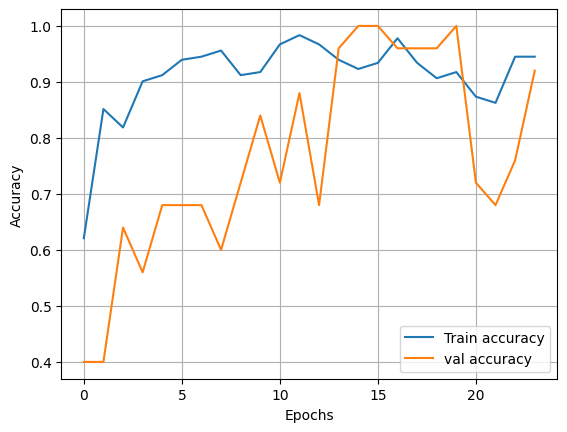

In [ ]:
plt.plot(history.history['accuracy'], label = 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.grid()

In [ ]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.grid()

##CNN+RF

In [ ]:
best_model = load_model('/kaggle/working/best.keras')

In [ ]:
# Extract features using CNN
def extract_features(dataset, model):
    features = []
    labels = []
    for images, batch_labels in dataset:
        batch_features = model.predict(images)
        features.extend(batch_features)
        labels.extend(batch_labels.numpy())
    return np.array(features), np.array(labels)

In [ ]:
train_features, train_labels = extract_features(train_data, best_model)
val_features, val_labels = extract_features(test_data, best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 694ms/step


In [ ]:
# Prepare labels for Random Forest
train_labels = np.argmax(train_labels, axis=1)
val_labels = np.argmax(val_labels, axis=1)

In [ ]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)

RandomForestClassifier(random_state=42)

In [ ]:
# Predictions
val_pred = rf_model.predict(val_features)
val_pred_proba = rf_model.predict_proba(val_features)

In [ ]:
# Evaluation
accuracy = accuracy_score(val_labels, val_pred)
f1 = f1_score(val_labels, val_pred, average='weighted')
auc = roc_auc_score(val_labels, val_pred_proba, multi_class='ovr', average='weighted')

In [ ]:
print(f"Accuracy: {accuracy:.10f}")
print(f"F1-score: {f1:.10f}")
print(f"AUC: {auc:.10f}")

Accuracy: 0.9803921569
F1-score: 0.9801338975
AUC: 1.0000000000


In [ ]:
# Assuming val_labels, val_pred, and train_data.class_names are already defined
print("\nClassification Report:")
print(classification_report(val_labels, val_pred, target_names=train_data.class_names, digits=10))


Classification Report:
              precision    recall  f1-score   support

    aneurysm  1.0000000000 0.9090909091 0.9523809524        11
      cancer  0.9583333333 1.0000000000 0.9787234043        23
       tumor  1.0000000000 1.0000000000 1.0000000000        17

    accuracy                      0.9803921569        51
   macro avg  0.9861111111 0.9696969697 0.9770347855        51
weighted avg  0.9812091503 0.9803921569 0.9801338975        51

